In [ ]:
#GRU
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 1

#数据缩放 拆分输入X（6维）&输出Y（1维）
X = dataset[:,5]
X_scaler= (X-np.min(X))/(np.max(X)-np.min(X))
X_scaler = X_scaler.reshape(324,1)
print(X_scaler.shape)

Y = dataset[:,5]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(inputs)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='relu')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,(5)]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)


In [ ]:
#GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,1]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(inputs)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,1]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)


(324, 1)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 60)             14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             3504      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 18,457
Trainable params: 18,457
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples
Epoch 1/700
246/246 [==============================] -

246/246 [==============================] - 0s 182us/sample - loss: 0.0032
Epoch 83/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0033
Epoch 84/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0031
Epoch 85/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0031
Epoch 86/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0032
Epoch 87/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0032
Epoch 88/700
246/246 [==============================] - 0s 182us/sample - loss: 0.0034
Epoch 89/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0032
Epoch 90/700
246/246 [==============================] - 0s 183us/sample - loss: 0.0032
Epoch 91/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0032
Epoch 92/700
246/246 [==============================] - 0s 211us/sample - loss: 0.0031
Epoch 93/700
246/246 [==============================] - 

246/246 [==============================] - 0s 166us/sample - loss: 0.0028
Epoch 176/700
246/246 [==============================] - 0s 199us/sample - loss: 0.0028
Epoch 177/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0024
Epoch 178/700
246/246 [==============================] - 0s 203us/sample - loss: 0.0025
Epoch 179/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0022
Epoch 180/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0024
Epoch 181/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0023
Epoch 182/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0023
Epoch 183/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0023
Epoch 184/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0024
Epoch 185/700
246/246 [==============================] - 0s 182us/sample - loss: 0.0025
Epoch 186/700
246/246 [=======================

Epoch 268/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0020
Epoch 269/700
246/246 [==============================] - 0s 170us/sample - loss: 0.0021
Epoch 270/700
246/246 [==============================] - 0s 162us/sample - loss: 0.0020
Epoch 271/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0019
Epoch 272/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0020
Epoch 273/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0023
Epoch 274/700
246/246 [==============================] - 0s 162us/sample - loss: 0.0024
Epoch 275/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0023
Epoch 276/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0023
Epoch 277/700
246/246 [==============================] - 0s 162us/sample - loss: 0.0022
Epoch 278/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0020
Epoch 279/700
246/246 [=========

246/246 [==============================] - 0s 308us/sample - loss: 0.0012
Epoch 362/700
246/246 [==============================] - 0s 215us/sample - loss: 0.0013
Epoch 363/700
246/246 [==============================] - 0s 223us/sample - loss: 0.0013
Epoch 364/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0013
Epoch 365/700
246/246 [==============================] - 0s 239us/sample - loss: 0.0013
Epoch 366/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0013
Epoch 367/700
246/246 [==============================] - 0s 231us/sample - loss: 0.0012
Epoch 368/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0013
Epoch 369/700
246/246 [==============================] - 0s 235us/sample - loss: 0.0013
Epoch 370/700
246/246 [==============================] - 0s 203us/sample - loss: 0.0014
Epoch 371/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0012
Epoch 372/700
246/246 [=======================

246/246 [==============================] - 0s 223us/sample - loss: 0.0016
Epoch 453/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0012
Epoch 454/700
246/246 [==============================] - 0s 203us/sample - loss: 0.0011
Epoch 455/700
246/246 [==============================] - 0s 207us/sample - loss: 0.0010
Epoch 456/700
246/246 [==============================] - 0s 191us/sample - loss: 8.9088e-04
Epoch 457/700
246/246 [==============================] - 0s 195us/sample - loss: 8.8271e-04
Epoch 458/700
246/246 [==============================] - 0s 199us/sample - loss: 0.0010
Epoch 459/700
246/246 [==============================] - 0s 191us/sample - loss: 9.3596e-04
Epoch 460/700
246/246 [==============================] - 0s 182us/sample - loss: 8.7503e-04
Epoch 461/700
246/246 [==============================] - 0s 182us/sample - loss: 8.6944e-04
Epoch 462/700
246/246 [==============================] - 0s 215us/sample - loss: 8.0028e-04
Epoch 463/700
246/246 

246/246 [==============================] - 0s 166us/sample - loss: 6.5910e-04
Epoch 542/700
246/246 [==============================] - 0s 178us/sample - loss: 5.5142e-04
Epoch 543/700
246/246 [==============================] - 0s 142us/sample - loss: 6.5990e-04
Epoch 544/700
246/246 [==============================] - 0s 142us/sample - loss: 6.8596e-04
Epoch 545/700
246/246 [==============================] - 0s 142us/sample - loss: 7.4282e-04
Epoch 546/700
246/246 [==============================] - 0s 138us/sample - loss: 7.2655e-04
Epoch 547/700
246/246 [==============================] - 0s 142us/sample - loss: 5.4856e-04
Epoch 548/700
246/246 [==============================] - 0s 199us/sample - loss: 6.0106e-04
Epoch 549/700
246/246 [==============================] - 0s 243us/sample - loss: 5.8747e-04
Epoch 550/700
246/246 [==============================] - 0s 195us/sample - loss: 5.3868e-04
Epoch 551/700
246/246 [==============================] - 0s 166us/sample - loss: 5.1133e-04
Ep

246/246 [==============================] - 0s 142us/sample - loss: 7.2265e-04
Epoch 631/700
246/246 [==============================] - 0s 142us/sample - loss: 6.0066e-04
Epoch 632/700
246/246 [==============================] - 0s 138us/sample - loss: 4.9118e-04
Epoch 633/700
246/246 [==============================] - 0s 146us/sample - loss: 4.7821e-04
Epoch 634/700
246/246 [==============================] - 0s 146us/sample - loss: 5.2034e-04
Epoch 635/700
246/246 [==============================] - 0s 142us/sample - loss: 5.7985e-04
Epoch 636/700
246/246 [==============================] - 0s 142us/sample - loss: 5.0285e-04
Epoch 637/700
246/246 [==============================] - 0s 142us/sample - loss: 4.7637e-04
Epoch 638/700
246/246 [==============================] - 0s 142us/sample - loss: 4.7658e-04
Epoch 639/700
246/246 [==============================] - 0s 146us/sample - loss: 4.2846e-04
Epoch 640/700
246/246 [==============================] - 0s 142us/sample - loss: 3.4476e-04
Ep

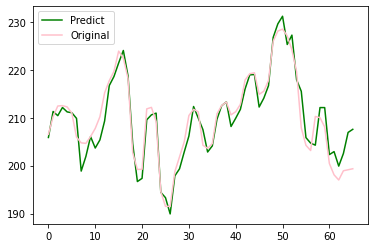

In [2]:
#LSTM
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 1

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,5]
X_scaler= (X-np.min(X))/(np.max(X)-np.min(X))
X_scaler = X_scaler.reshape(324,1)
print(X_scaler.shape)

Y = dataset[:,5]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_lstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    lstm_out1 = LSTM(lstm_units1, return_sequences=True)(inputs)
    lstm_out2 = LSTM(lstm_units2, return_sequences=True)(lstm_out1)
    lstm_out = Flatten()(lstm_out2)
    output = Dense(1, activation='relu')(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_lstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)

(324, 2)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 2)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 60)             15120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             3504      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 18,697
Trainable params: 18,697
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples
Epoch 1/700
246/246 [==============================] -

246/246 [==============================] - 0s 247us/sample - loss: 0.0026
Epoch 83/700
246/246 [==============================] - 0s 207us/sample - loss: 0.0027
Epoch 84/700
246/246 [==============================] - 0s 199us/sample - loss: 0.0026
Epoch 85/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0026
Epoch 86/700
246/246 [==============================] - 0s 182us/sample - loss: 0.0027
Epoch 87/700
246/246 [==============================] - 0s 199us/sample - loss: 0.0029
Epoch 88/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0029
Epoch 89/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0028
Epoch 90/700
246/246 [==============================] - 0s 187us/sample - loss: 0.0029
Epoch 91/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0029
Epoch 92/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0028
Epoch 93/700
246/246 [==============================] - 

246/246 [==============================] - 0s 158us/sample - loss: 0.0020
Epoch 176/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0022
Epoch 177/700
246/246 [==============================] - 0s 182us/sample - loss: 0.0019
Epoch 178/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0019
Epoch 179/700
246/246 [==============================] - 0s 170us/sample - loss: 0.0022
Epoch 180/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0022
Epoch 181/700
246/246 [==============================] - 0s 186us/sample - loss: 0.0023
Epoch 182/700
246/246 [==============================] - 0s 170us/sample - loss: 0.0021
Epoch 183/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0022
Epoch 184/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0019
Epoch 185/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0020
Epoch 186/700
246/246 [=======================

246/246 [==============================] - 0s 182us/sample - loss: 0.0020
Epoch 269/700
246/246 [==============================] - 0s 211us/sample - loss: 0.0024
Epoch 270/700
246/246 [==============================] - 0s 182us/sample - loss: 0.0021
Epoch 271/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0018
Epoch 272/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0021
Epoch 273/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0020
Epoch 274/700
246/246 [==============================] - 0s 166us/sample - loss: 0.0020
Epoch 275/700
246/246 [==============================] - 0s 199us/sample - loss: 0.0019
Epoch 276/700
246/246 [==============================] - 0s 178us/sample - loss: 0.0018
Epoch 277/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0018
Epoch 278/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0016
Epoch 279/700
246/246 [=======================

246/246 [==============================] - 0s 154us/sample - loss: 7.3712e-04
Epoch 360/700
246/246 [==============================] - 0s 191us/sample - loss: 7.3411e-04
Epoch 361/700
246/246 [==============================] - 0s 162us/sample - loss: 9.6607e-04
Epoch 362/700
246/246 [==============================] - 0s 195us/sample - loss: 8.9225e-04
Epoch 363/700
246/246 [==============================] - 0s 186us/sample - loss: 8.7221e-04
Epoch 364/700
246/246 [==============================] - 0s 182us/sample - loss: 7.4789e-04
Epoch 365/700
246/246 [==============================] - 0s 182us/sample - loss: 6.7313e-04
Epoch 366/700
246/246 [==============================] - 0s 186us/sample - loss: 6.2382e-04
Epoch 367/700
246/246 [==============================] - 0s 178us/sample - loss: 6.6524e-04
Epoch 368/700
246/246 [==============================] - 0s 186us/sample - loss: 6.4448e-04
Epoch 369/700
246/246 [==============================] - 0s 178us/sample - loss: 6.3453e-04
Ep

246/246 [==============================] - 0s 203us/sample - loss: 6.7390e-04
Epoch 449/700
246/246 [==============================] - 0s 178us/sample - loss: 8.3061e-04
Epoch 450/700
246/246 [==============================] - 0s 191us/sample - loss: 7.6930e-04
Epoch 451/700
246/246 [==============================] - 0s 182us/sample - loss: 5.8091e-04
Epoch 452/700
246/246 [==============================] - 0s 170us/sample - loss: 6.3091e-04
Epoch 453/700
246/246 [==============================] - 0s 182us/sample - loss: 7.1362e-04
Epoch 454/700
246/246 [==============================] - 0s 174us/sample - loss: 7.3661e-04
Epoch 455/700
246/246 [==============================] - 0s 182us/sample - loss: 7.4810e-04
Epoch 456/700
246/246 [==============================] - 0s 174us/sample - loss: 6.5498e-04
Epoch 457/700
246/246 [==============================] - 0s 207us/sample - loss: 6.3988e-04
Epoch 458/700
246/246 [==============================] - 0s 170us/sample - loss: 7.2276e-04
Ep

246/246 [==============================] - 0s 195us/sample - loss: 3.8648e-04
Epoch 538/700
246/246 [==============================] - 0s 174us/sample - loss: 3.7442e-04
Epoch 539/700
246/246 [==============================] - 0s 203us/sample - loss: 3.8052e-04
Epoch 540/700
246/246 [==============================] - 0s 178us/sample - loss: 3.6299e-04
Epoch 541/700
246/246 [==============================] - 0s 191us/sample - loss: 3.7989e-04
Epoch 542/700
246/246 [==============================] - 0s 186us/sample - loss: 4.9774e-04
Epoch 543/700
246/246 [==============================] - 0s 187us/sample - loss: 4.3425e-04
Epoch 544/700
246/246 [==============================] - 0s 178us/sample - loss: 4.1478e-04
Epoch 545/700
246/246 [==============================] - 0s 203us/sample - loss: 4.1481e-04
Epoch 546/700
246/246 [==============================] - 0s 162us/sample - loss: 3.8828e-04
Epoch 547/700
246/246 [==============================] - 0s 186us/sample - loss: 3.6329e-04
Ep

246/246 [==============================] - 0s 178us/sample - loss: 1.7775e-04
Epoch 627/700
246/246 [==============================] - 0s 211us/sample - loss: 1.6575e-04
Epoch 628/700
246/246 [==============================] - 0s 186us/sample - loss: 1.5602e-04
Epoch 629/700
246/246 [==============================] - 0s 166us/sample - loss: 1.7873e-04
Epoch 630/700
246/246 [==============================] - 0s 186us/sample - loss: 1.9148e-04
Epoch 631/700
246/246 [==============================] - 0s 178us/sample - loss: 2.3513e-04
Epoch 632/700
246/246 [==============================] - 0s 186us/sample - loss: 2.5643e-04
Epoch 633/700
246/246 [==============================] - 0s 162us/sample - loss: 1.9870e-04
Epoch 634/700
246/246 [==============================] - 0s 195us/sample - loss: 1.9079e-04
Epoch 635/700
246/246 [==============================] - 0s 162us/sample - loss: 2.1040e-04
Epoch 636/700
246/246 [==============================] - 0s 162us/sample - loss: 1.3876e-04
Ep

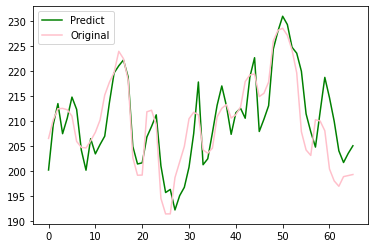

In [4]:
#LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,1]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_lstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    lstm_out1 = LSTM(lstm_units1, return_sequences=True)(inputs)
    lstm_out2 = LSTM(lstm_units2, return_sequences=True)(lstm_out1)
    lstm_out = Flatten()(lstm_out2)
    output = Dense(1, activation='relu')(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_lstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,1]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)

(324, 1)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 120)            29760     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             6384      
_________________________________________________________________
dropout (Dropout)            (None, 6, 12)             0         
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 36,217
Trainable params: 36,217
Non-trainable params: 0
______________

246/246 [==============================] - 0s 255us/sample - loss: 0.0058
Epoch 82/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0071
Epoch 83/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0062
Epoch 84/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0065
Epoch 85/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0073
Epoch 86/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0066
Epoch 87/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0054
Epoch 88/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0053
Epoch 89/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0056
Epoch 90/700
246/246 [==============================] - 0s 231us/sample - loss: 0.0063
Epoch 91/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0051
Epoch 92/700
246/246 [==============================] - 

246/246 [==============================] - 0s 259us/sample - loss: 0.0046
Epoch 175/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0046
Epoch 176/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0039
Epoch 177/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0038
Epoch 178/700
246/246 [==============================] - 0s 235us/sample - loss: 0.0044
Epoch 179/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0041
Epoch 180/700
246/246 [==============================] - 0s 239us/sample - loss: 0.0036
Epoch 181/700
246/246 [==============================] - 0s 243us/sample - loss: 0.0038
Epoch 182/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0039
Epoch 183/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0040
Epoch 184/700
246/246 [==============================] - 0s 231us/sample - loss: 0.0038
Epoch 185/700
246/246 [=======================

246/246 [==============================] - 0s 251us/sample - loss: 0.0037
Epoch 268/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0031
Epoch 269/700
246/246 [==============================] - 0s 243us/sample - loss: 0.0032
Epoch 270/700
246/246 [==============================] - 0s 292us/sample - loss: 0.0034
Epoch 271/700
246/246 [==============================] - 0s 296us/sample - loss: 0.0037
Epoch 272/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0037
Epoch 273/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0032
Epoch 274/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0033
Epoch 275/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0032
Epoch 276/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0030
Epoch 277/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0036
Epoch 278/700
246/246 [=======================

246/246 [==============================] - 0s 239us/sample - loss: 0.0030
Epoch 361/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0034
Epoch 362/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0030
Epoch 363/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0029
Epoch 364/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0026
Epoch 365/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0032
Epoch 366/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0029
Epoch 367/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0027
Epoch 368/700
246/246 [==============================] - 0s 243us/sample - loss: 0.0028
Epoch 369/700
246/246 [==============================] - 0s 304us/sample - loss: 0.0031
Epoch 370/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0031
Epoch 371/700
246/246 [=======================

246/246 [==============================] - 0s 377us/sample - loss: 0.0025
Epoch 454/700
246/246 [==============================] - 0s 377us/sample - loss: 0.0026
Epoch 455/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0026
Epoch 456/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0024
Epoch 457/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0027
Epoch 458/700
246/246 [==============================] - 0s 239us/sample - loss: 0.0026
Epoch 459/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0036
Epoch 460/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0029
Epoch 461/700
246/246 [==============================] - 0s 296us/sample - loss: 0.0030
Epoch 462/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0023
Epoch 463/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0028
Epoch 464/700
246/246 [=======================

246/246 [==============================] - 0s 268us/sample - loss: 0.0027
Epoch 547/700
246/246 [==============================] - 0s 304us/sample - loss: 0.0025
Epoch 548/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0021
Epoch 549/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0023
Epoch 550/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0025
Epoch 551/700
246/246 [==============================] - ETA: 0s - loss: 0.002 - 0s 272us/sample - loss: 0.0023
Epoch 552/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0021
Epoch 553/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0022
Epoch 554/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0027
Epoch 555/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0024
Epoch 556/700
246/246 [==============================] - 0s 300us/sample - loss: 0.0021
Epoch 557/700
246/246 

Epoch 639/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0018
Epoch 640/700
246/246 [==============================] - 0s 239us/sample - loss: 0.0022
Epoch 641/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0021
Epoch 642/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0020
Epoch 643/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0019
Epoch 644/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0018
Epoch 645/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0021
Epoch 646/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0018
Epoch 647/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0021
Epoch 648/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0020
Epoch 649/700
246/246 [==============================] - 0s 296us/sample - loss: 0.0021
Epoch 650/700
246/246 [=========

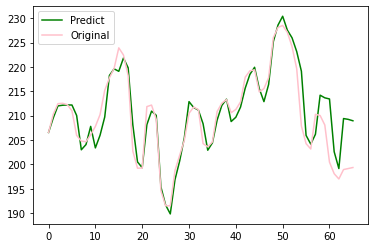

In [5]:
#Bi-LSTM
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 1

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,5]
X_scaler= (X-np.min(X))/(np.max(X)-np.min(X))
X_scaler = X_scaler.reshape(324,1)
print(X_scaler.shape)

Y = dataset[:,5]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_bilstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    bilstm_out1 = Bidirectional(LSTM(lstm_units1,return_sequences=True),merge_mode='concat')(inputs)
    bilstm_out2 = LSTM(lstm_units2, return_sequences=True)(bilstm_out1)
    dropout_out = Dropout(0.5)(bilstm_out2)
    bilstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(bilstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_bilstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)

(324, 2)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 2)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 120)            30240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             6384      
_________________________________________________________________
dropout (Dropout)            (None, 6, 12)             0         
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 36,697
Trainable params: 36,697
Non-trainable params: 0
______________

246/246 [==============================] - 0s 264us/sample - loss: 0.0049
Epoch 82/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0045
Epoch 83/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0056
Epoch 84/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0064
Epoch 85/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0065
Epoch 86/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0067
Epoch 87/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0066
Epoch 88/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0064
Epoch 89/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0062
Epoch 90/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0058
Epoch 91/700
246/246 [==============================] - 0s 239us/sample - loss: 0.0051
Epoch 92/700
246/246 [==============================] - 

246/246 [==============================] - 0s 280us/sample - loss: 0.0037
Epoch 175/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0039
Epoch 176/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0039
Epoch 177/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0042
Epoch 178/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0034
Epoch 179/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0034
Epoch 180/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0033
Epoch 181/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0035
Epoch 182/700
246/246 [==============================] - 0s 247us/sample - loss: 0.0034
Epoch 183/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0037
Epoch 184/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0035
Epoch 185/700
246/246 [=======================

246/246 [==============================] - 0s 247us/sample - loss: 0.0041
Epoch 268/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0040
Epoch 269/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0032
Epoch 270/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0035
Epoch 271/700
246/246 [==============================] - 0s 304us/sample - loss: 0.0036
Epoch 272/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0038
Epoch 273/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0032
Epoch 274/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0031
Epoch 275/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0029
Epoch 276/700
246/246 [==============================] - 0s 243us/sample - loss: 0.0034
Epoch 277/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0036
Epoch 278/700
246/246 [=======================

Epoch 360/700
246/246 [==============================] - 0s 482us/sample - loss: 0.0028
Epoch 361/700
246/246 [==============================] - 0s 328us/sample - loss: 0.0026
Epoch 362/700
246/246 [==============================] - 0s 320us/sample - loss: 0.0029
Epoch 363/700
246/246 [==============================] - 0s 324us/sample - loss: 0.0026
Epoch 364/700
246/246 [==============================] - 0s 361us/sample - loss: 0.0033
Epoch 365/700
246/246 [==============================] - 0s 361us/sample - loss: 0.0032
Epoch 366/700
246/246 [==============================] - 0s 316us/sample - loss: 0.0029
Epoch 367/700
246/246 [==============================] - 0s 320us/sample - loss: 0.0025
Epoch 368/700
246/246 [==============================] - 0s 332us/sample - loss: 0.0030
Epoch 369/700
246/246 [==============================] - 0s 430us/sample - loss: 0.0029
Epoch 370/700
246/246 [==============================] - 0s 312us/sample - loss: 0.0029
Epoch 371/700
246/246 [=========

246/246 [==============================] - 0s 272us/sample - loss: 0.0028
Epoch 454/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0027
Epoch 455/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0025
Epoch 456/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0027
Epoch 457/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0024
Epoch 458/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0022
Epoch 459/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0021
Epoch 460/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0026
Epoch 461/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0025
Epoch 462/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0024
Epoch 463/700
246/246 [==============================] - 0s 251us/sample - loss: 0.0025
Epoch 464/700
246/246 [=======================

246/246 [==============================] - 0s 284us/sample - loss: 0.0022
Epoch 547/700
246/246 [==============================] - 0s 304us/sample - loss: 0.0022
Epoch 548/700
246/246 [==============================] - 0s 284us/sample - loss: 0.0022
Epoch 549/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0023
Epoch 550/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0021
Epoch 551/700
246/246 [==============================] - 0s 284us/sample - loss: 0.0021
Epoch 552/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0020
Epoch 553/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0019
Epoch 554/700
246/246 [==============================] - 0s 255us/sample - loss: 0.0017
Epoch 555/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0019
Epoch 556/700
246/246 [==============================] - 0s 276us/sample - loss: 0.0020
Epoch 557/700
246/246 [=======================

246/246 [==============================] - 0s 288us/sample - loss: 0.0016
Epoch 640/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0019
Epoch 641/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0014
Epoch 642/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0017
Epoch 643/700
246/246 [==============================] - 0s 296us/sample - loss: 0.0017
Epoch 644/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0015
Epoch 645/700
246/246 [==============================] - 0s 280us/sample - loss: 0.0017
Epoch 646/700
246/246 [==============================] - 0s 259us/sample - loss: 0.0018
Epoch 647/700
246/246 [==============================] - 0s 272us/sample - loss: 0.0020
Epoch 648/700
246/246 [==============================] - 0s 264us/sample - loss: 0.0016
Epoch 649/700
246/246 [==============================] - 0s 268us/sample - loss: 0.0018
Epoch 650/700
246/246 [=======================

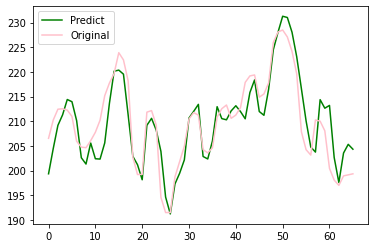

In [9]:
#Bi-LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 2

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:2]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,1]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_bilstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    bilstm_out1 = Bidirectional(LSTM(lstm_units1,return_sequences=True),merge_mode='concat')(inputs)
    bilstm_out2 = LSTM(lstm_units2, return_sequences=True)(bilstm_out1)
    dropout_out = Dropout(0.5)(bilstm_out2)
    bilstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(bilstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_bilstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX2.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,1]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)

(324, 3)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 3)]       0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 6)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3, 6)         42          permute[0][0]                    
__________________________________________________________________________________________________
attention_vec (Permute)         (None, 6, 3)         0           dense[0][0]                      
___________________________________________________

246/246 [==============================] - 0s 158us/sample - loss: 0.0042
Epoch 68/700
246/246 [==============================] - 0s 191us/sample - loss: 0.0044
Epoch 69/700
246/246 [==============================] - 0s 158us/sample - loss: 0.0042
Epoch 70/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0046
Epoch 71/700
246/246 [==============================] - 0s 146us/sample - loss: 0.0046
Epoch 72/700
246/246 [==============================] - 0s 174us/sample - loss: 0.0044
Epoch 73/700
246/246 [==============================] - 0s 162us/sample - loss: 0.0042
Epoch 74/700
246/246 [==============================] - 0s 207us/sample - loss: 0.0058
Epoch 75/700
246/246 [==============================] - 0s 146us/sample - loss: 0.0044
Epoch 76/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0041
Epoch 77/700
246/246 [==============================] - 0s 158us/sample - loss: 0.0041
Epoch 78/700
246/246 [==============================] - 

246/246 [==============================] - 0s 142us/sample - loss: 0.0023
Epoch 161/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0025
Epoch 162/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0026
Epoch 163/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0024
Epoch 164/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0021
Epoch 165/700
246/246 [==============================] - 0s 146us/sample - loss: 0.0022
Epoch 166/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0022
Epoch 167/700
246/246 [==============================] - 0s 146us/sample - loss: 0.0020
Epoch 168/700
246/246 [==============================] - 0s 146us/sample - loss: 0.0021
Epoch 169/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0026
Epoch 170/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0023
Epoch 171/700
246/246 [=======================

Epoch 253/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0021
Epoch 254/700
246/246 [==============================] - 0s 154us/sample - loss: 0.0017
Epoch 255/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0018
Epoch 256/700
246/246 [==============================] - 0s 162us/sample - loss: 0.0016
Epoch 257/700
246/246 [==============================] - 0s 130us/sample - loss: 0.0015
Epoch 258/700
246/246 [==============================] - 0s 126us/sample - loss: 0.0015
Epoch 259/700
246/246 [==============================] - 0s 130us/sample - loss: 0.0015
Epoch 260/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0015
Epoch 261/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0013
Epoch 262/700
246/246 [==============================] - 0s 142us/sample - loss: 0.0013
Epoch 263/700
246/246 [==============================] - 0s 138us/sample - loss: 0.0014
Epoch 264/700
246/246 [=========

246/246 [==============================] - 0s 134us/sample - loss: 0.0010
Epoch 346/700
246/246 [==============================] - 0s 182us/sample - loss: 9.6994e-04
Epoch 347/700
246/246 [==============================] - 0s 255us/sample - loss: 8.7035e-04
Epoch 348/700
246/246 [==============================] - 0s 320us/sample - loss: 9.3305e-04
Epoch 349/700
246/246 [==============================] - 0s 272us/sample - loss: 8.2960e-04
Epoch 350/700
246/246 [==============================] - 0s 223us/sample - loss: 9.2945e-04
Epoch 351/700
246/246 [==============================] - 0s 195us/sample - loss: 0.0010
Epoch 352/700
246/246 [==============================] - 0s 191us/sample - loss: 9.7130e-04
Epoch 353/700
246/246 [==============================] - 0s 138us/sample - loss: 9.6123e-04
Epoch 354/700
246/246 [==============================] - 0s 126us/sample - loss: 9.0539e-04
Epoch 355/700
246/246 [==============================] - 0s 130us/sample - loss: 9.7607e-04
Epoch 356/

246/246 [==============================] - 0s 150us/sample - loss: 7.7911e-04
Epoch 435/700
246/246 [==============================] - 0s 138us/sample - loss: 8.9015e-04
Epoch 436/700
246/246 [==============================] - 0s 134us/sample - loss: 6.6649e-04
Epoch 437/700
246/246 [==============================] - 0s 126us/sample - loss: 6.0906e-04
Epoch 438/700
246/246 [==============================] - 0s 134us/sample - loss: 5.6602e-04
Epoch 439/700
246/246 [==============================] - 0s 130us/sample - loss: 5.3083e-04
Epoch 440/700
246/246 [==============================] - 0s 134us/sample - loss: 5.3525e-04
Epoch 441/700
246/246 [==============================] - 0s 138us/sample - loss: 5.0680e-04
Epoch 442/700
246/246 [==============================] - 0s 138us/sample - loss: 6.3054e-04
Epoch 443/700
246/246 [==============================] - 0s 134us/sample - loss: 6.0619e-04
Epoch 444/700
246/246 [==============================] - 0s 126us/sample - loss: 5.8607e-04
Ep

246/246 [==============================] - 0s 130us/sample - loss: 3.6242e-04
Epoch 524/700
246/246 [==============================] - 0s 130us/sample - loss: 4.7344e-04
Epoch 525/700
246/246 [==============================] - 0s 134us/sample - loss: 4.8262e-04
Epoch 526/700
246/246 [==============================] - 0s 134us/sample - loss: 4.5267e-04
Epoch 527/700
246/246 [==============================] - 0s 154us/sample - loss: 4.8964e-04
Epoch 528/700
246/246 [==============================] - 0s 134us/sample - loss: 4.5278e-04
Epoch 529/700
246/246 [==============================] - 0s 126us/sample - loss: 4.9082e-04
Epoch 530/700
246/246 [==============================] - 0s 134us/sample - loss: 6.0143e-04
Epoch 531/700
246/246 [==============================] - 0s 134us/sample - loss: 7.9967e-04
Epoch 532/700
246/246 [==============================] - 0s 138us/sample - loss: 6.2057e-04
Epoch 533/700
246/246 [==============================] - 0s 138us/sample - loss: 6.3920e-04
Ep

246/246 [==============================] - 0s 142us/sample - loss: 1.8274e-04
Epoch 613/700
246/246 [==============================] - 0s 138us/sample - loss: 1.4369e-04
Epoch 614/700
246/246 [==============================] - 0s 134us/sample - loss: 1.9292e-04
Epoch 615/700
246/246 [==============================] - 0s 134us/sample - loss: 1.8926e-04
Epoch 616/700
246/246 [==============================] - 0s 134us/sample - loss: 1.5518e-04
Epoch 617/700
246/246 [==============================] - 0s 134us/sample - loss: 1.5476e-04
Epoch 618/700
246/246 [==============================] - 0s 130us/sample - loss: 1.4413e-04
Epoch 619/700
246/246 [==============================] - 0s 130us/sample - loss: 1.4968e-04
Epoch 620/700
246/246 [==============================] - 0s 130us/sample - loss: 1.4470e-04
Epoch 621/700
246/246 [==============================] - 0s 126us/sample - loss: 1.5206e-04
Epoch 622/700
246/246 [==============================] - 0s 130us/sample - loss: 1.2713e-04
Ep

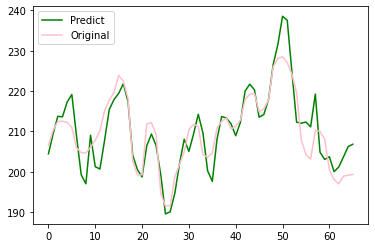

In [11]:
#AT_GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 3

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,3:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,5]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(timestep, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    attention_mul = attention_3d_block(inputs)
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(attention_mul)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model




#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=700, batch_size=64)

    pre=model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    testPredict = pre*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,5]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)
